# SWB Regression Pipeline - Theta Power 
Created: 07/30/24 \
Updated: 08/19/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08192024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
theta_df = pd.read_csv(f'{save_dir}theta_master_df.csv')
theta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [12]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

# # keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
# #     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# # keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
# # keep_rois


# Test Single Electrode Regressions 

In [10]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(theta_df,reg_formula,elec_col, main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4089.59it/s]


In [11]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [12]:
results = single_elec_permutation_results(results_dict,theta_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,-0.001462,0.034537,0.105812,0.017878,0.022017,0.000597,...,0.047227,0.046055,-0.667212,0.667212,2.264301,0.392825,0.504637,0.504637,0.023556,0.694448
1,MS002_lacas2-lacas3,MS002,acc,14,-0.032605,0.069301,0.045877,0.025164,0.015206,0.000188,...,0.038625,0.039178,-1.625628,1.625628,1.188466,0.650456,0.104029,0.104029,0.234650,0.515397
2,MS002_lacas3-lacas4,MS002,acc,14,-0.032618,0.081636,-0.016179,-0.006422,0.024231,-0.000541,...,0.044877,0.046230,-1.609746,1.609746,-0.343568,-0.137577,0.107453,0.107453,0.731171,0.890575
3,MS002_lacas4-lacas5,MS002,acc,14,-0.003928,0.025701,-0.004925,0.054597,0.013823,0.000041,...,0.047332,0.050040,-0.524173,0.524173,-0.066790,1.059346,0.600158,0.600158,0.946749,0.289442
4,MS002_lacas5-lacas6,MS002,acc,14,0.013442,0.054870,0.010259,-0.022066,0.051441,-0.000058,...,0.049129,0.046491,-1.062038,1.062038,0.184187,-0.508296,0.288218,0.288218,0.853867,0.611246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,DA039_rtp6-rtp7,DA039,temporal pole,22,-0.065973,0.012027,-0.004228,-0.075846,-0.060921,-0.001154,...,0.044106,0.041543,-0.293143,0.293143,-0.068957,-1.811111,0.769413,0.769413,0.945024,0.070124
1876,DA039_rtp7-rtp8,DA039,temporal pole,22,-0.076831,0.069817,-0.062332,-0.018346,-0.049026,-0.002720,...,0.051714,0.051353,-1.392050,1.392050,-1.229750,-0.305673,0.163907,0.163907,0.218791,0.759853
1877,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.053244,0.044063,-0.095024,-0.058377,-0.035308,-0.002726,...,0.059025,0.058260,-0.763235,0.763235,-1.631457,-1.028592,0.445323,0.445323,0.102794,0.303671
1878,DA039_rsgcc7-rsgcc8,DA039,vlpfc,22,-0.053504,-0.005997,-0.084043,-0.148458,-0.057123,0.003442,...,0.059086,0.061432,0.155997,-0.155997,-1.390400,-2.418952,0.876036,0.876036,0.164407,0.015565


In [13]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_theta_{reg_formula}_{date}.pkl',"wb"))

In [14]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
25,MS002_lhplt1-lhplt2,MS002,hpc,14,-0.095421,0.136187,0.017970,0.094458,-0.001638,0.000621,...,0.048076,0.047468,-2.575453,2.575453,0.384827,1.998858,0.010011,0.010011,0.700365,0.045624
33,MS002_lloif1-lloif2,MS002,ofc,14,-0.009216,0.051506,0.027011,0.111326,0.025381,0.001495,...,0.051904,0.049290,-0.929949,0.929949,0.443958,2.237741,0.352398,0.352398,0.657073,0.025238
43,MS002_lmoif11-lmoif12,MS002,vlpfc,14,-0.115870,0.096581,-0.003324,0.120594,-0.047295,-0.002547,...,0.052887,0.052843,-1.726784,1.726784,-0.025092,2.289789,0.084207,0.084207,0.979981,0.022034
50,MS002_lpips10-lpips11,MS002,dlpfc,14,-0.009762,0.028918,-0.025683,0.106828,0.011748,-0.002176,...,0.053848,0.054520,-0.517838,0.517838,-0.470210,1.965823,0.604572,0.604572,0.638205,0.049319
52,MS002_lpips12-lpips13,MS002,dmpfc,14,-0.040345,0.042002,-0.032596,0.131156,-0.010168,-0.001619,...,0.055977,0.055693,-0.700240,0.700240,-0.562543,2.373478,0.483777,0.483777,0.573746,0.017621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,DA037_rpins2-rpins3,DA037,pins,4,-0.523139,-0.195886,0.237722,-0.203538,-0.569402,0.000732,...,0.103056,0.102683,1.589018,-1.589018,2.288351,-1.965387,0.112056,0.112056,0.022117,0.049370
1823,DA039_rains3-rains4,DA039,ains,22,-0.106942,0.070205,-0.092550,-0.155820,-0.080527,0.001298,...,0.064983,0.065474,-1.057758,1.057758,-1.410765,-2.361129,0.290166,0.290166,0.158314,0.018219
1826,DA039_rains6-rains7,DA039,ains,22,-0.109475,0.154414,-0.105584,-0.147975,-0.050392,0.000285,...,0.074320,0.069578,-2.223652,2.223652,-1.344818,-2.166796,0.026172,0.026172,0.178684,0.030250
1836,DA039_rfp1-rfp2,DA039,vmpfc,22,-0.028006,-0.080254,-0.012793,-0.113327,-0.058400,-0.000963,...,0.055552,0.056909,1.453567,-1.453567,-0.203537,-1.994366,0.146066,0.146066,0.838715,0.046112


In [15]:
sig_data.roi.value_counts()

acc              22
dmpfc            21
sts              16
dlpfc            15
mtg              15
ofc              13
amy              11
ains             10
hpc               9
pins              6
vmpfc             5
smg               5
vlpfc             4
phg               4
stg               4
mcc               3
angular           3
itg               2
fusiform          2
temporal pole     1
premotor          1
occipital         1
parietal          1
Name: roi, dtype: int64

In [16]:
sig_data.roi.unique()

array(['hpc', 'ofc', 'vlpfc', 'dlpfc', 'dmpfc', 'mtg', 'ains', 'sts',
       'phg', 'fusiform', 'temporal pole', 'mcc', 'vmpfc', 'smg', 'acc',
       'angular', nan, 'premotor', 'amy', 'stg', 'pins', 'occipital',
       'parietal', 'itg'], dtype=object)

In [17]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


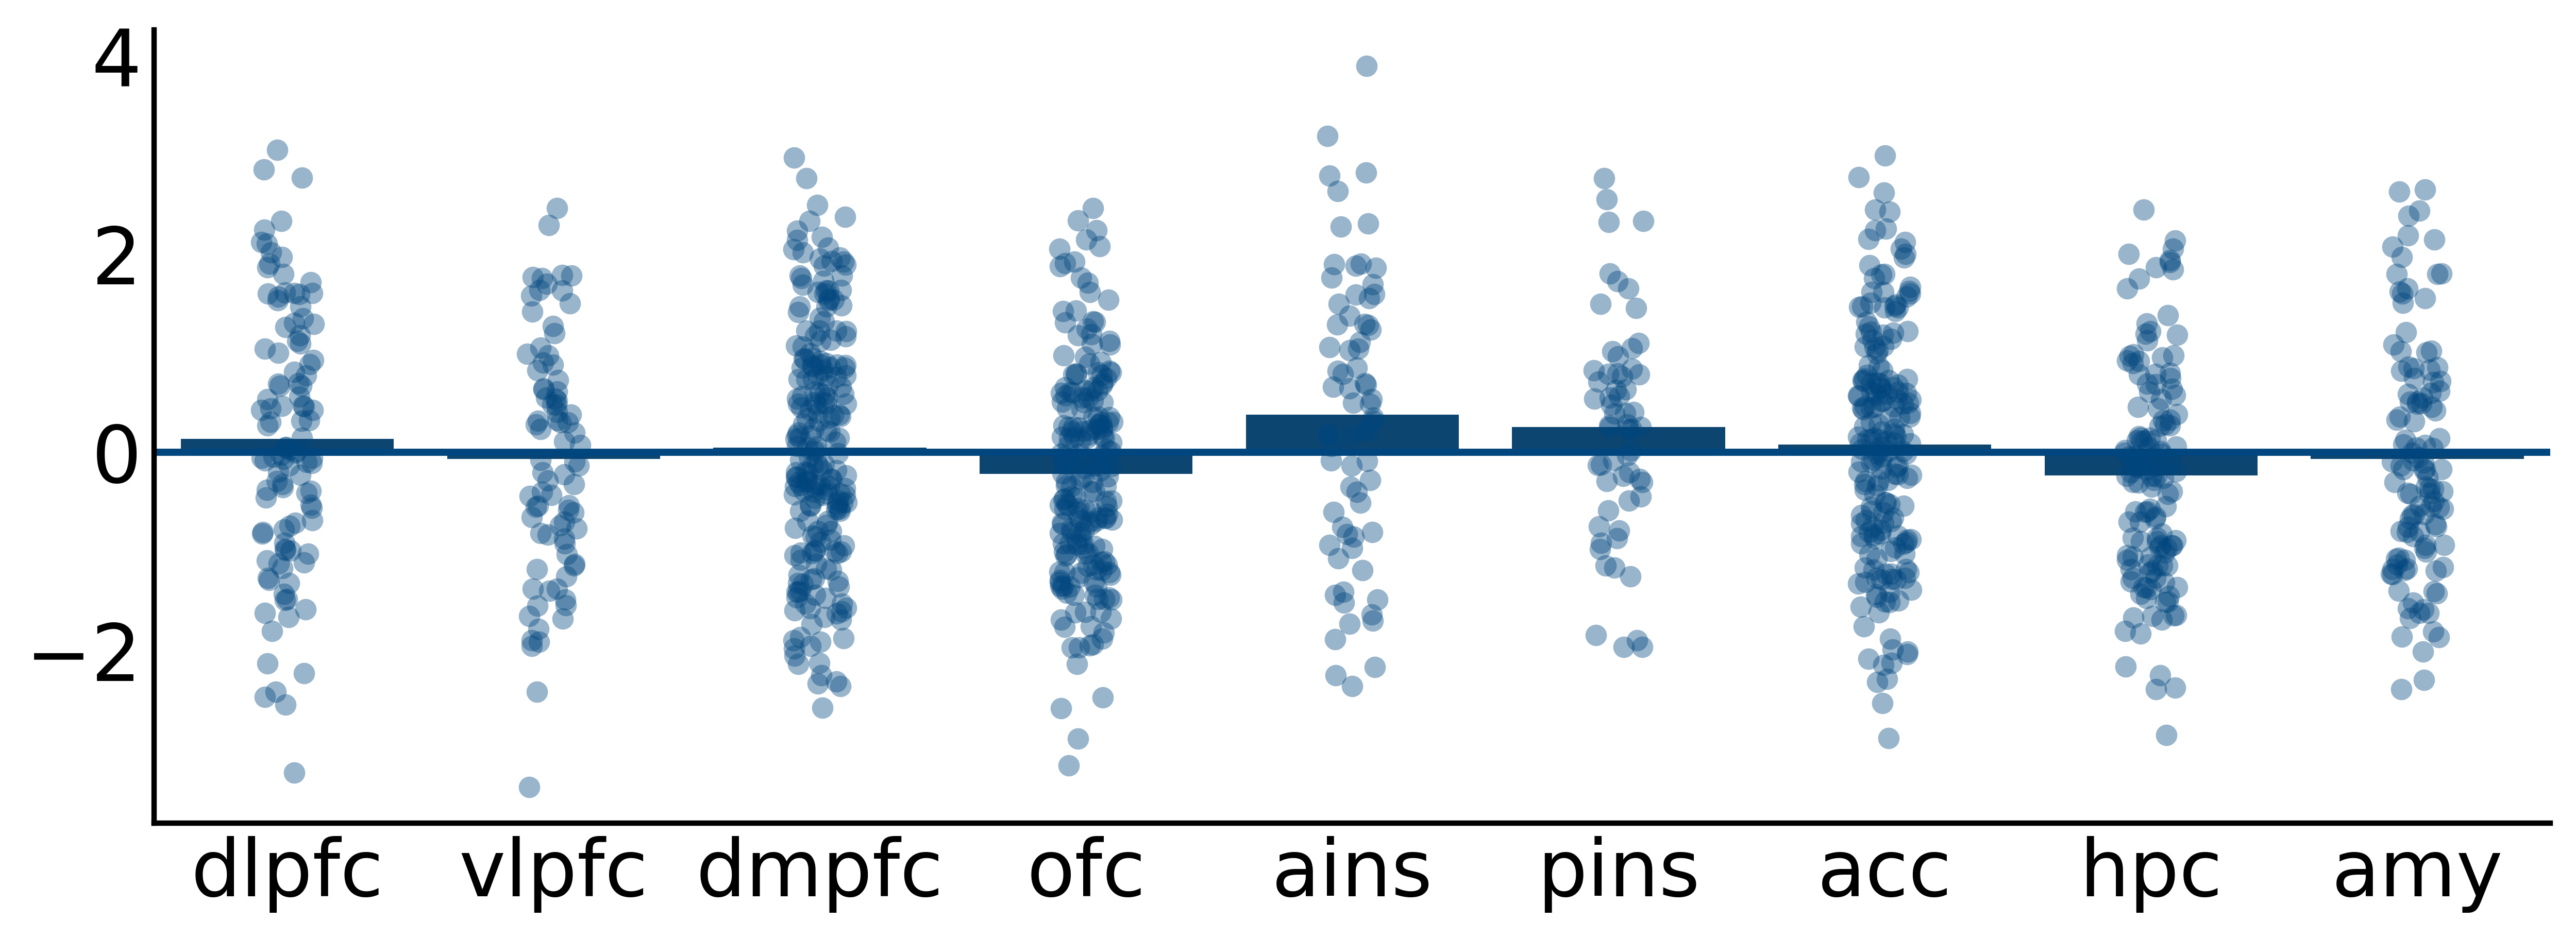

In [18]:
plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='#00467e')
# green '#135546'


In [19]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]

roi
dlpfc    0.135333
vlpfc   -0.067050
dmpfc    0.046102
ofc     -0.220943
ains     0.375346
pins     0.251091
acc      0.078216
hpc     -0.234407
amy     -0.068333
Name: Z_Score_decisionCPE, dtype: float64

In [20]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,-0.001462,0.034537,0.105812,0.017878,0.022017,0.000597,...,0.047227,0.046055,-0.667212,0.667212,2.264301,0.392825,0.504637,0.504637,0.023556,0.694448
1,MS002_lacas2-lacas3,MS002,acc,14,-0.032605,0.069301,0.045877,0.025164,0.015206,0.000188,...,0.038625,0.039178,-1.625628,1.625628,1.188466,0.650456,0.104029,0.104029,0.234650,0.515397
2,MS002_lacas3-lacas4,MS002,acc,14,-0.032618,0.081636,-0.016179,-0.006422,0.024231,-0.000541,...,0.044877,0.046230,-1.609746,1.609746,-0.343568,-0.137577,0.107453,0.107453,0.731171,0.890575
3,MS002_lacas4-lacas5,MS002,acc,14,-0.003928,0.025701,-0.004925,0.054597,0.013823,0.000041,...,0.047332,0.050040,-0.524173,0.524173,-0.066790,1.059346,0.600158,0.600158,0.946749,0.289442
4,MS002_lacas5-lacas6,MS002,acc,14,0.013442,0.054870,0.010259,-0.022066,0.051441,-0.000058,...,0.049129,0.046491,-1.062038,1.062038,0.184187,-0.508296,0.288218,0.288218,0.853867,0.611246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,DA039_rpins1-rpins2,DA039,pins,22,0.027859,0.046165,-0.167112,0.056161,0.045078,0.001246,...,0.069742,0.069816,-0.641163,0.641163,-2.354041,0.789615,0.521417,0.521417,0.018571,0.429753
1863,DA039_rpins2-rpins3,DA039,pins,22,-0.012486,0.072155,-0.125805,-0.008237,0.015114,0.000157,...,0.058953,0.056769,-1.244630,1.244630,-2.097955,-0.128499,0.213268,0.213268,0.035909,0.897754
1864,DA039_rpins3-rpins4,DA039,pins,22,0.013243,-0.050785,-0.046033,-0.032130,-0.007719,0.003898,...,0.070002,0.069692,0.802703,-0.802703,-0.620564,-0.450054,0.422146,0.422146,0.534887,0.652671
1877,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.053244,0.044063,-0.095024,-0.058377,-0.035308,-0.002726,...,0.059025,0.058260,-0.763235,0.763235,-1.631457,-1.028592,0.445323,0.445323,0.102794,0.303671


In [21]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [22]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.078216
ains,0.375346
amy,-0.068333
dlpfc,0.135333
dmpfc,0.046102
hpc,-0.234407
ofc,-0.220943
pins,0.251091
vlpfc,-0.067050


In [23]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data

,rho,rho_p,Z_Score_decisionCPE
roi,,,
acc,0.061737,0.3937,0.078216
dmpfc,0.255710,0.0001,0.046102
amy,0.168223,0.0749,-0.068333
ains,-0.096585,0.4230,0.375346
vlpfc,-0.072577,0.5170,-0.067050
hpc,0.111385,0.1984,-0.234407
ofc,0.051183,0.4694,-0.220943
pins,-0.020696,0.8753,0.251091
dlpfc,0.350413,0.0002,0.135333


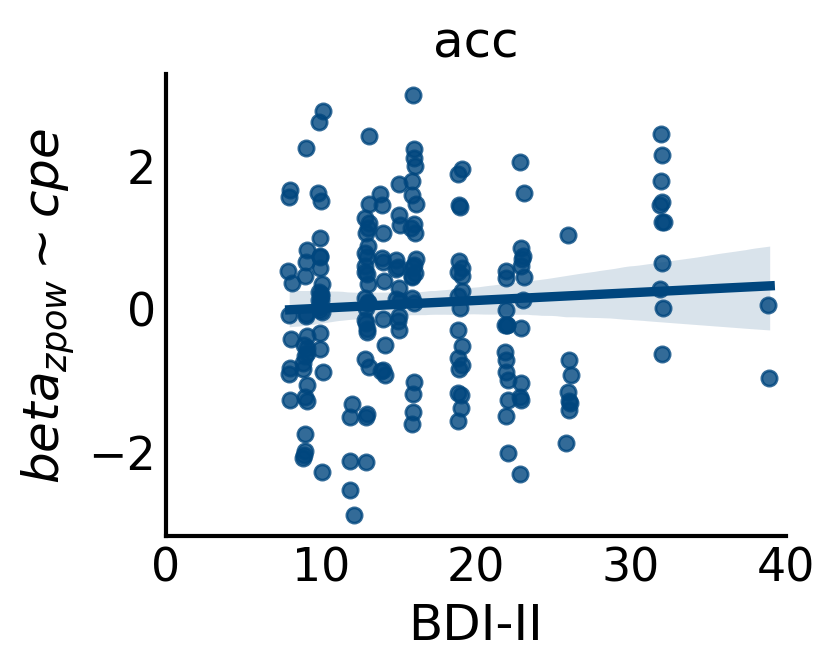

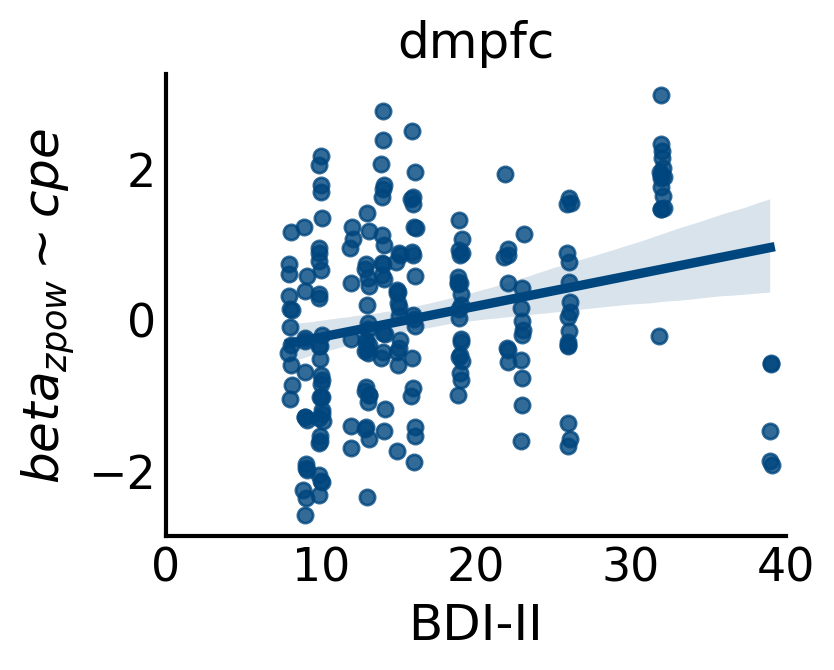

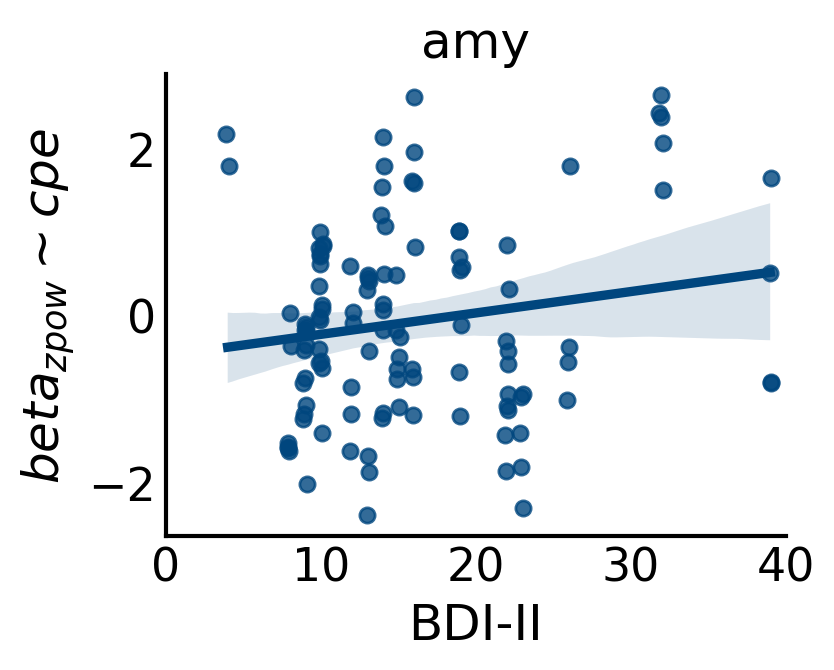

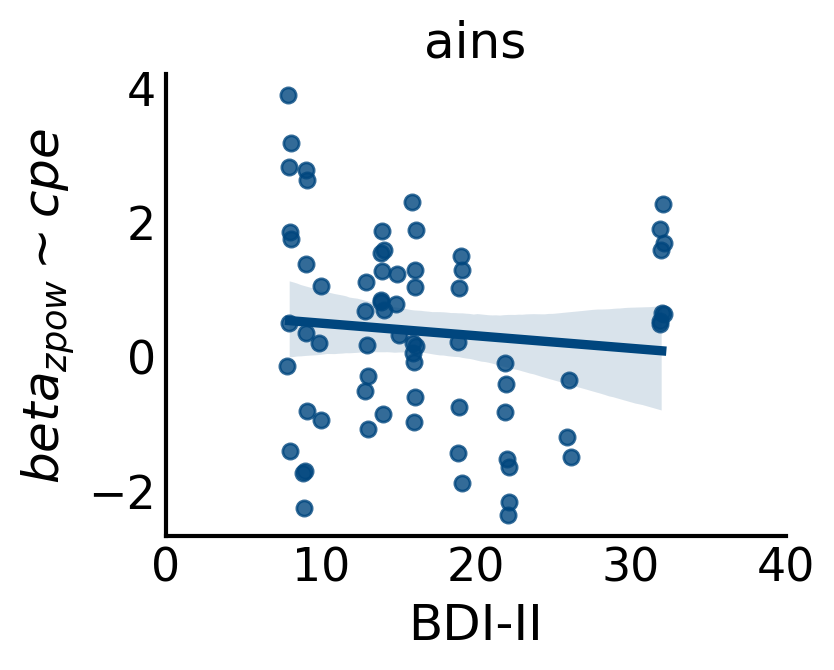

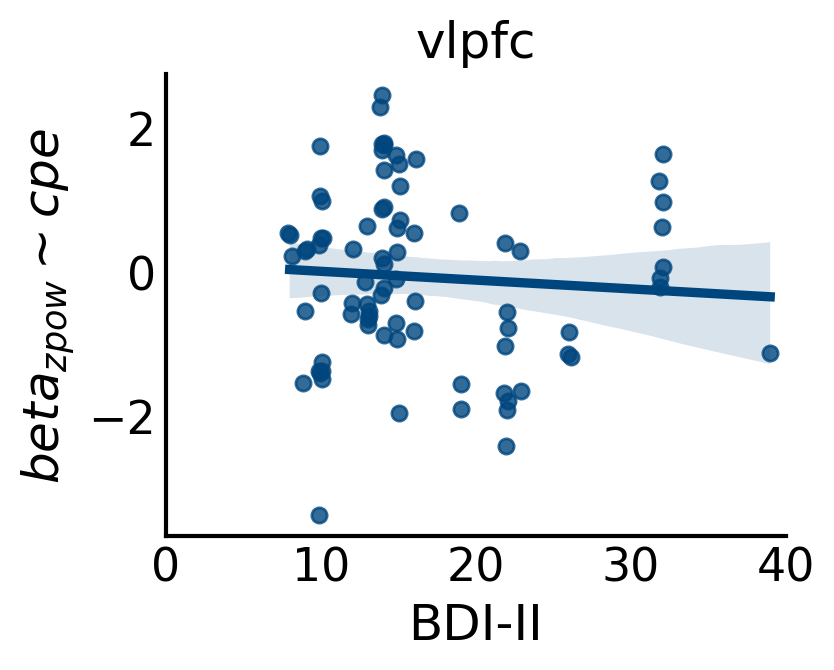

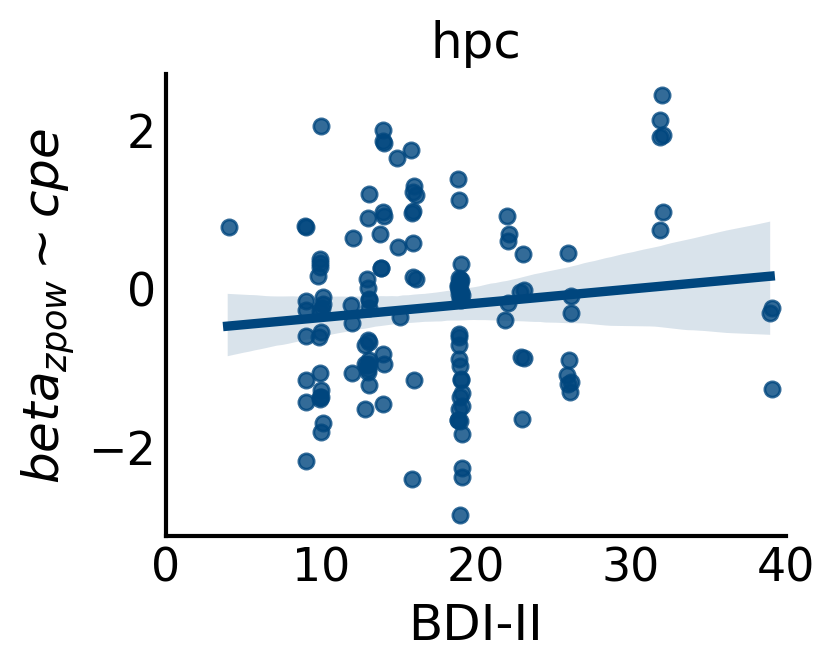

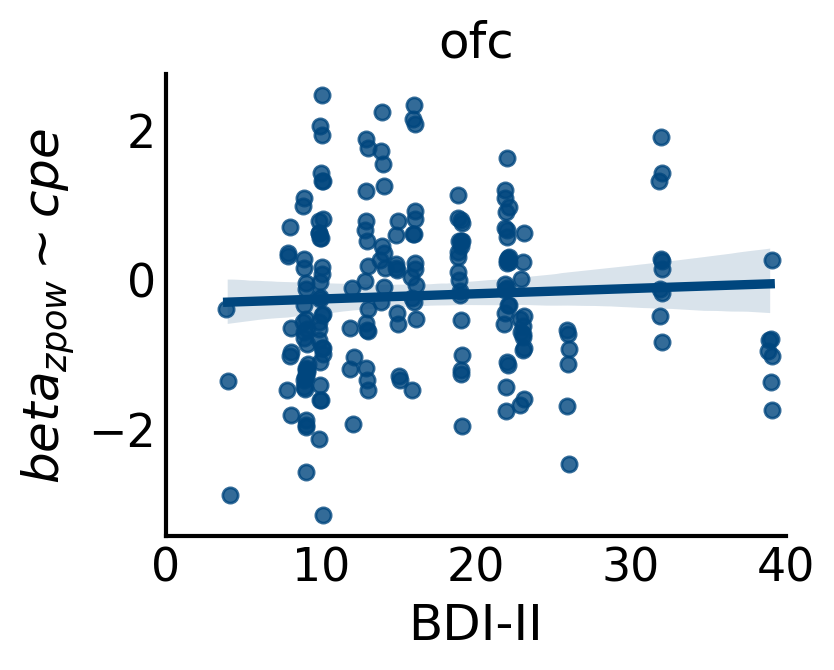

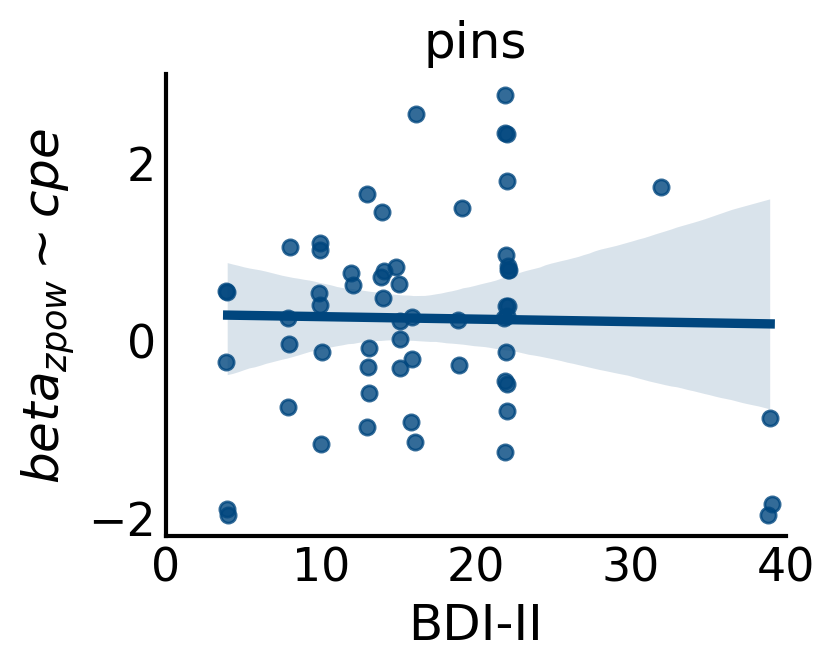

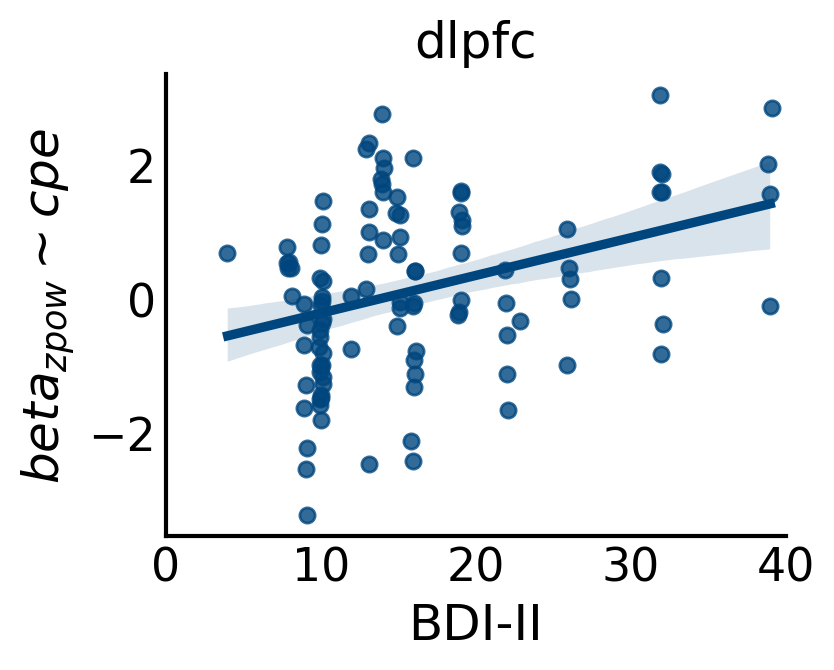

In [25]:
band = 'beta'

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()


# Mixed effects models

In [26]:
reg_df = theta_df.copy()
reg_df = reg_df[reg_df.roi.isin(bar_order)]
reg_df


,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,6.232769,theta,-0.243781,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,6.232769,theta,-0.178626,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,6.232769,theta,-0.249534,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,6.232769,theta,-0.000454,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,6.232769,theta,-0.265047,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258455,258455,DA039,22,rpins1-rpins2,DA039_rpins1-rpins2,148,6.232769,theta,-0.409039,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258456,258456,DA039,22,rpins2-rpins3,DA039_rpins2-rpins3,148,6.232769,theta,0.507177,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258457,258457,DA039,22,rpins3-rpins4,DA039_rpins3-rpins4,148,6.232769,theta,-0.351136,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,6.232769,theta,-0.059029,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [27]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [28]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [30]:
roi_fit_results['band'] = 'theta'
# roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [31]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,-0.001105,0.009376,0.011046,0.017085,-0.007324,-0.000673,0.000598,acc,0.5557,0.2113,0.3969
1,-0.022158,0.006738,-0.005925,-0.006408,-0.026144,-0.000203,0.001938,dmpfc,0.0341,0.7770,0.0038
2,-0.064473,-0.000868,-0.013132,0.018747,-0.039650,0.002143,0.002385,amy,0.0081,0.0039,0.0052
3,-0.013680,0.047090,-0.010775,-0.029488,0.027501,-0.000200,-0.000461,ains,0.2873,0.8638,0.7488
4,-0.039250,-0.005418,0.008639,0.003528,0.012592,-0.000209,-0.001012,vlpfc,0.5264,0.8652,0.3657
5,-0.144836,0.020104,-0.011034,-0.002558,-0.033840,0.002431,0.001255,hpc,0.0260,0.0903,0.1334
6,-0.049747,-0.004517,-0.018302,-0.000914,-0.017556,0.000601,0.000326,ofc,0.0869,0.3590,0.5625
7,-0.062750,0.026594,-0.018230,0.020463,0.021472,0.001348,-0.000913,pins,0.2890,0.4997,0.4070
8,0.006999,-0.007933,-0.015112,-0.008875,-0.040255,-0.001059,0.003095,dlpfc,0.0199,0.0621,0.0013


In [32]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [33]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

[]

In [34]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois

['dmpfc', 'amy', 'dlpfc']

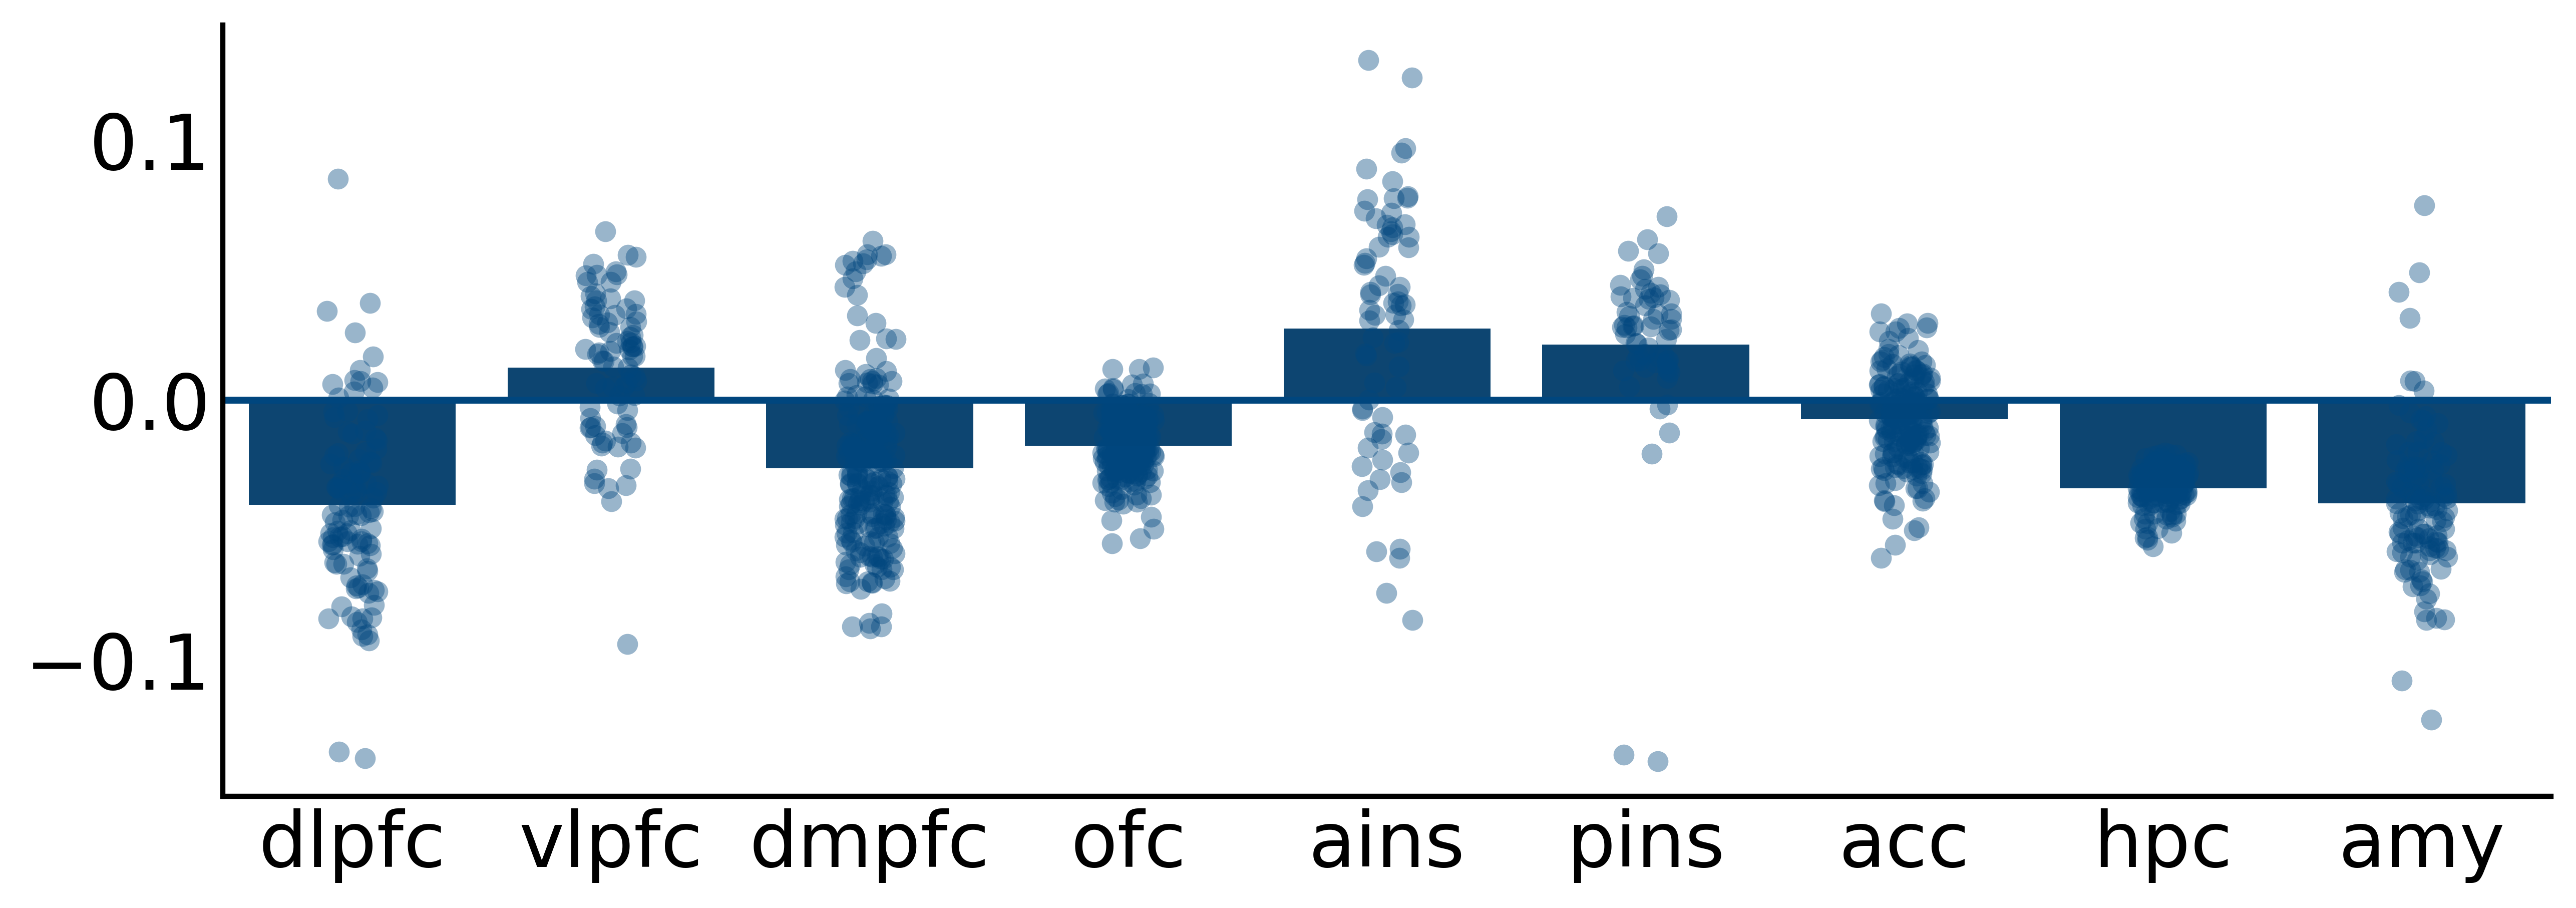

In [35]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#00467e')


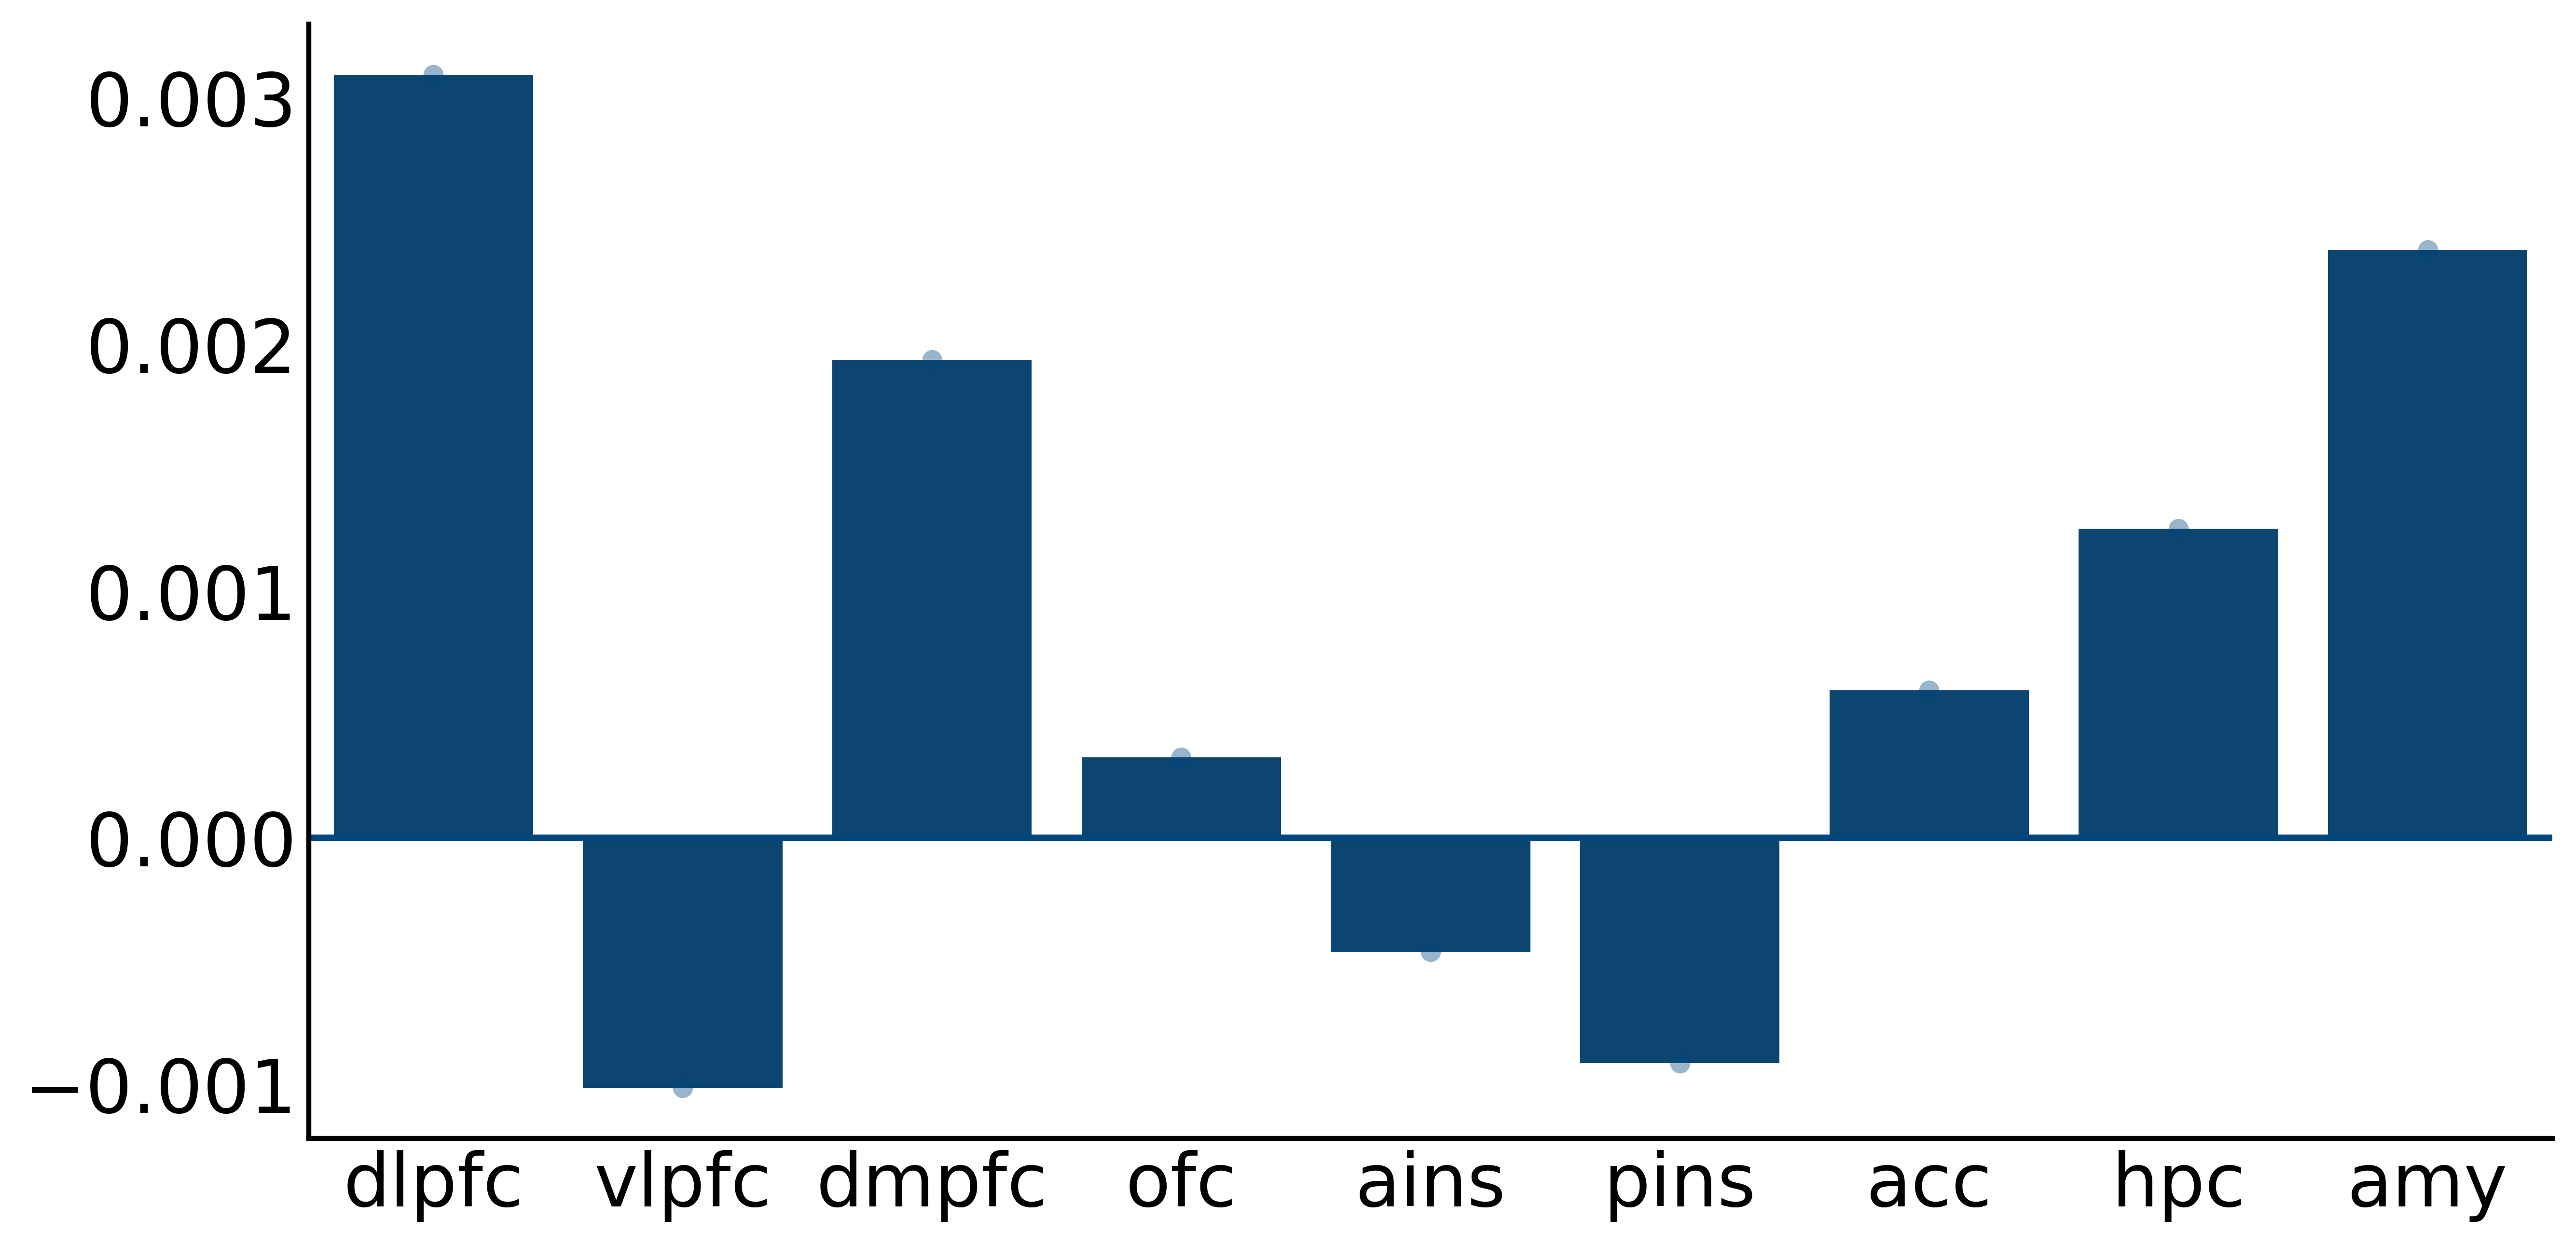

In [36]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#00467e')
# add to slides 
